## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, f1_score
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## **Load and Inspect the Dataset**

In [2]:
# Load the dataset
leads_data = pd.read_csv('Leads.csv')
leads_data.head() # Inspect the first few rows of the dataset

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
leads_data.shape  # Check the shape of the dataset

(9240, 37)

## **Data Cleaning**

In [4]:
leads_data.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [5]:
# Replace 'Select' with NaN for categorical variables
leads_data.replace('Select', np.nan, inplace=True)

In [6]:
# Drop columns with a high percentage of missing values
threshold = 0.3
leads_data.dropna(axis=1, thresh=leads_data.shape[0] * (1 - threshold), inplace=True)

# Drop rows with missing target variable if necessary
leads_data.dropna(subset=['Converted'], inplace=True)

In [7]:
leads_data.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

## **Exploratory Data Analysis (EDA)**

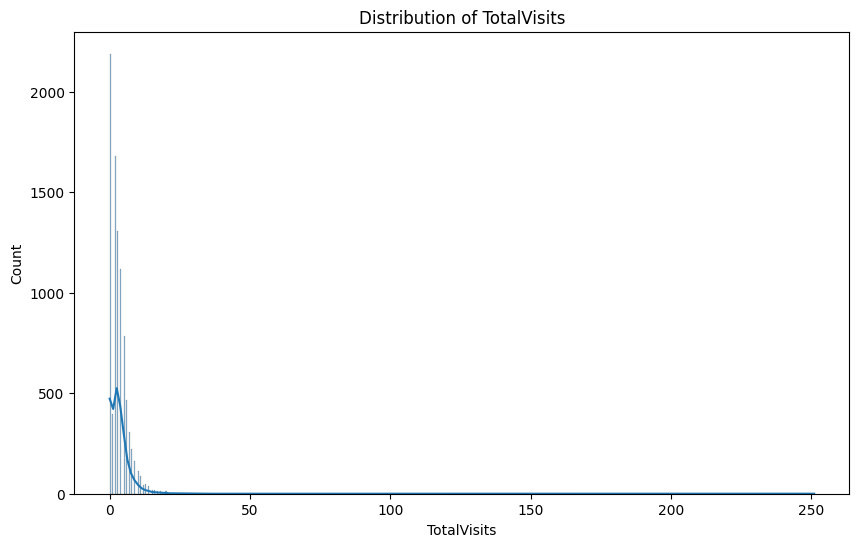

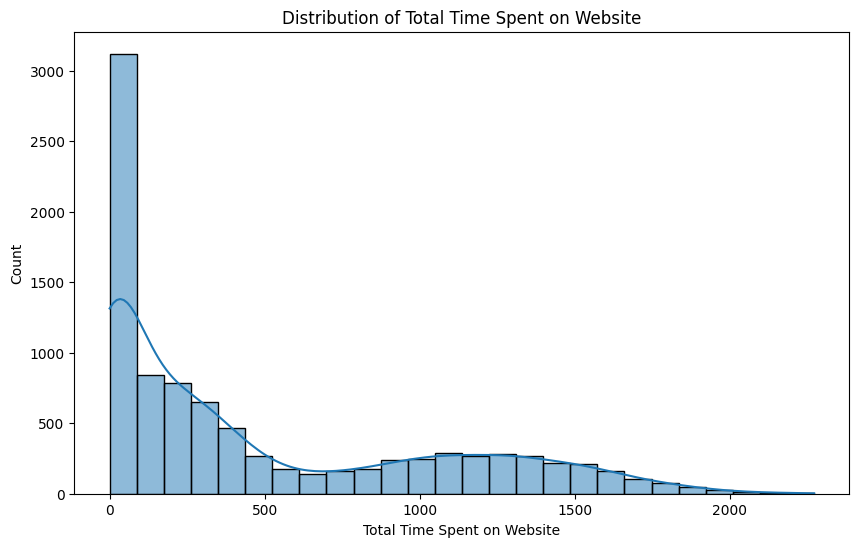

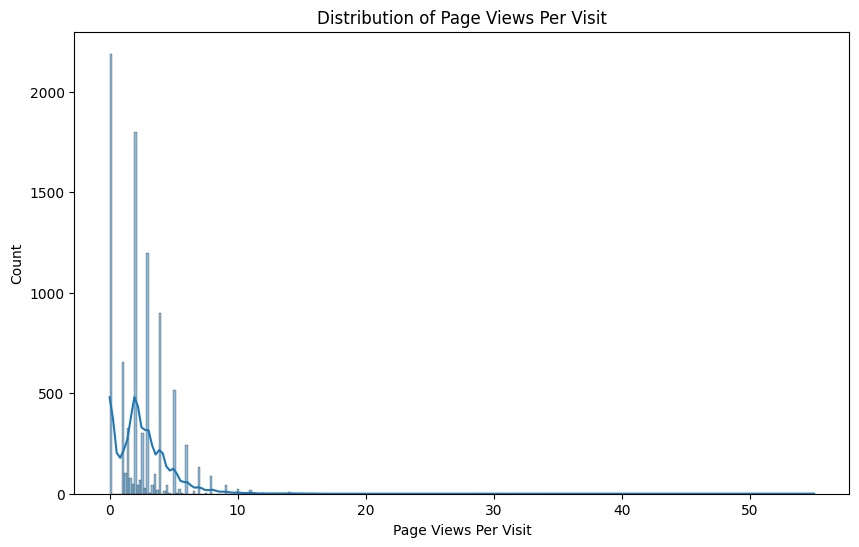

In [8]:
# Distribution of numerical features
numerical_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
for column in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(leads_data[column].dropna(), kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

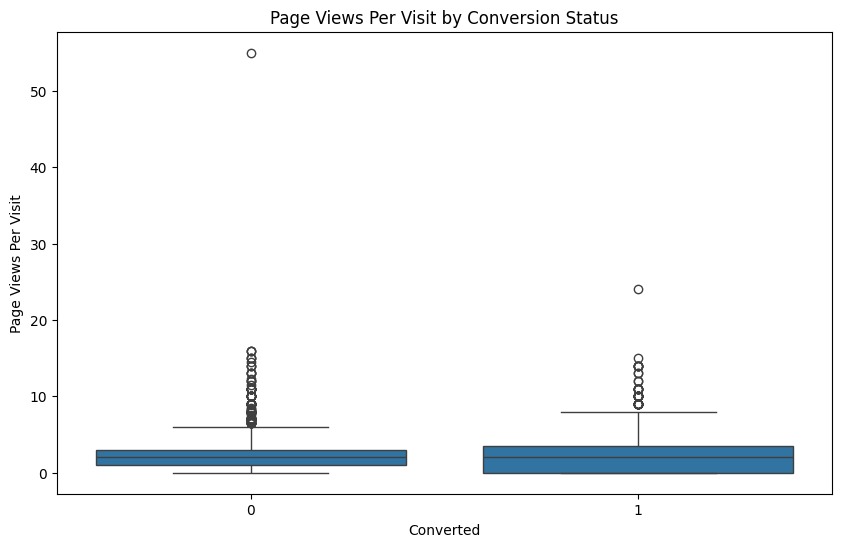

In [9]:
# Bivariate analysis with the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x='Converted', y=column, data=leads_data)
plt.title(f'{column} by Conversion Status')
plt.show()

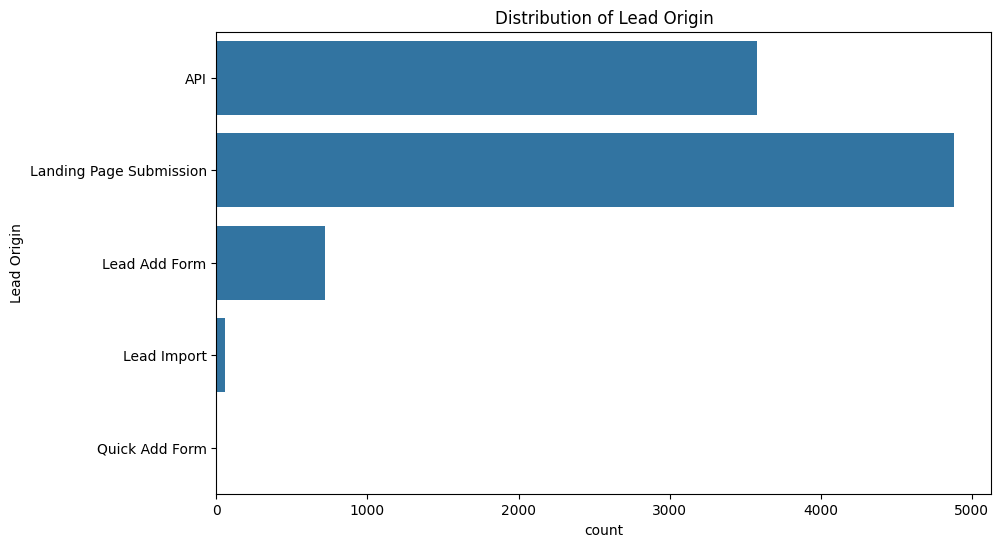

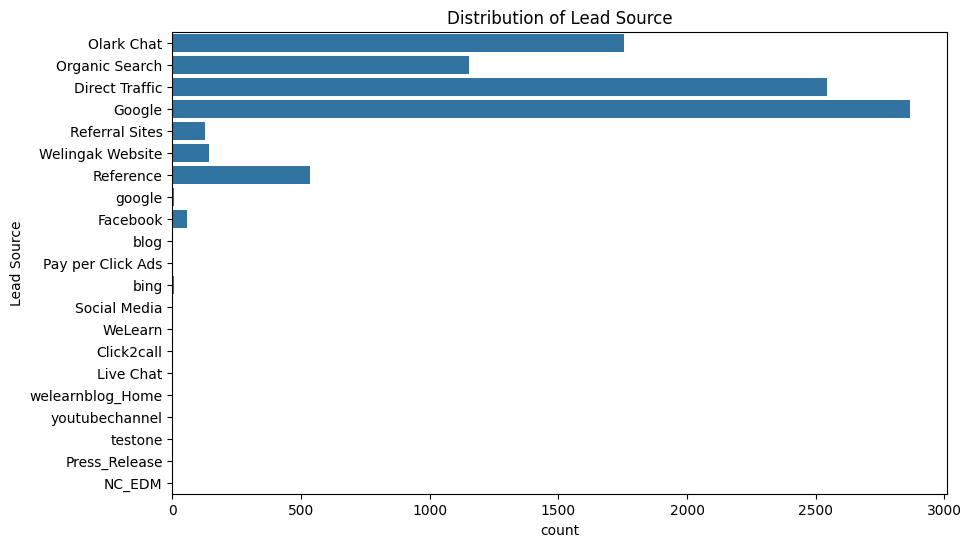

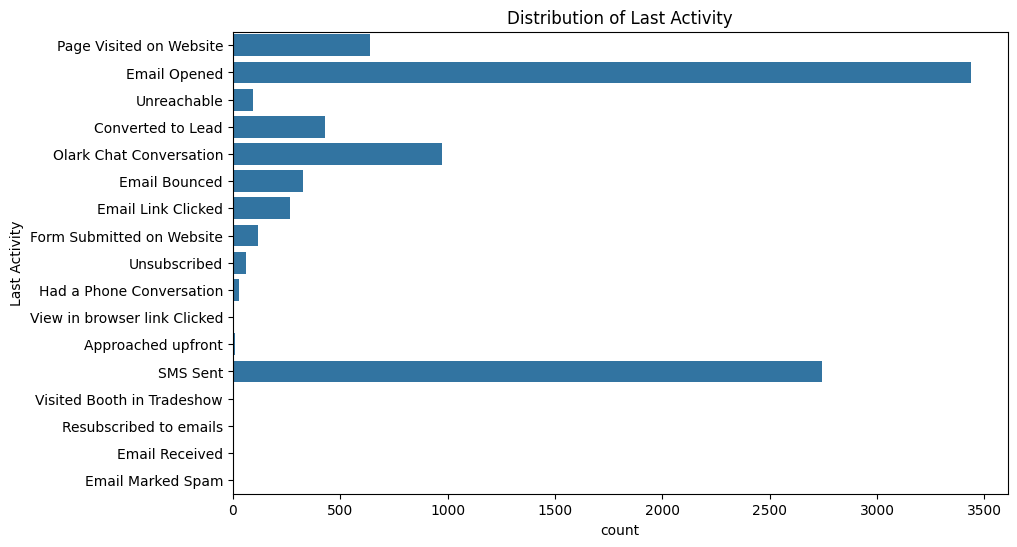

In [10]:
# Analysis of categorical features
categorical_features = ['Lead Origin', 'Lead Source', 'Last Activity']
for column in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=leads_data)
    plt.title(f'Distribution of {column}')
    plt.show()

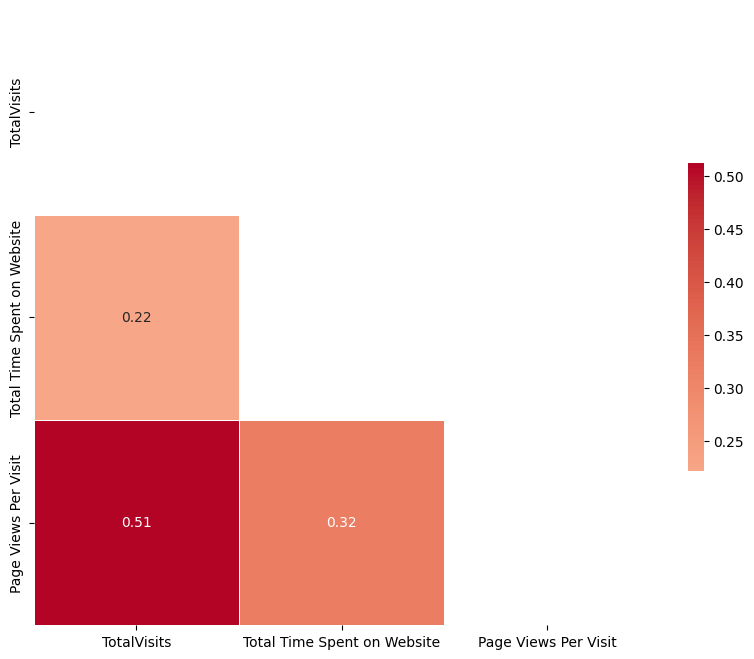

In [11]:
# Calculate the correlation matrix
corr = leads_data[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## **Data Preprocessing**

In [12]:
# Feature Engineering
leads_data['AvgTimePerVisit'] = leads_data['Total Time Spent on Website'] / leads_data['TotalVisits']
# Handle any potential division by zero or NaN values
leads_data['AvgTimePerVisit'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Additional Feature Engineering Examples
# You can add more feature engineering steps here
# Example: Interaction term between 'TotalVisits' and 'Page Views Per Visit'
leads_data['InteractionFeature'] = leads_data['TotalVisits'] * leads_data['Page Views Per Visit']

# Now handle any missing values that new features may have introduced
# It's important to handle NaN values for new features before splitting the data
leads_data.fillna(leads_data.mean(), inplace=True)


<ipython-input-12-32d15b76055f>:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  leads_data.fillna(leads_data.mean(), inplace=True)


In [13]:
# Split data into features and target BEFORE imputing missing values
X = leads_data.drop(['Converted'], axis=1)
y = leads_data['Converted']

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Identifying categorical features for preprocessing
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Creating dummies for categorical variables
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

In [16]:
# Ensuring both X_train and X_test have the same dummy variables
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

## **Feature Selection with RFE**

- Perform feature selection using Recursive Feature Elimination (RFE) with logistic regression as the estimator

In [17]:
# Creating a preprocessing pipeline for numerical data (assuming all of X_train is now numerical after encoding)
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [18]:
# Initialize the RFECV object
rfe = RFECV(estimator=LogisticRegression(solver='liblinear'), step=1, cv=5, scoring='accuracy')

# Fit RFECV to the imputed training data
rfe.fit(X_train_imputed, y_train)

# Applying the selection to both training and test sets correctly
X_train_rfe = rfe.transform(X_train_imputed)
X_test_rfe = rfe.transform(X_test_imputed)

In [19]:
# Validate the shapes
print(X_train_rfe.shape)  # This should match y_train's shape
print(y_train.shape)

(7392, 34)
(7392,)


## **Model Building**


In [20]:
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    LogisticRegression(solver='liblinear'),
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_rfe, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


## **Model Evaluation**

- Evaluate the trained model on the test set using accuracy, ROC AUC, and other performance metrics


In [21]:
# Evaluate the best_model's performance
y_pred = best_model.predict(X_test_rfe)
y_pred_proba = best_model.predict_proba(X_test_rfe)[:, 1]


In [22]:
# Calculate the accuracy score
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))

Accuracy on Test Set: 0.8317099567099567


In [23]:
# Generate a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1107
           1       0.83      0.73      0.78       741

    accuracy                           0.83      1848
   macro avg       0.83      0.81      0.82      1848
weighted avg       0.83      0.83      0.83      1848



In [24]:
# Generate the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[997 110]
 [201 540]]


In [25]:
# Calculate the ROC-AUC score
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))

ROC-AUC: 0.9044224765234607


In [26]:
# Precision-Recall Curve - Ensuring y_scores is based on best_model
# Ensure y_scores is based on the best_model, using the transformed test set if applicable
y_scores = best_model.predict_proba(X_test_rfe)[:, 1]

In [27]:
# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)


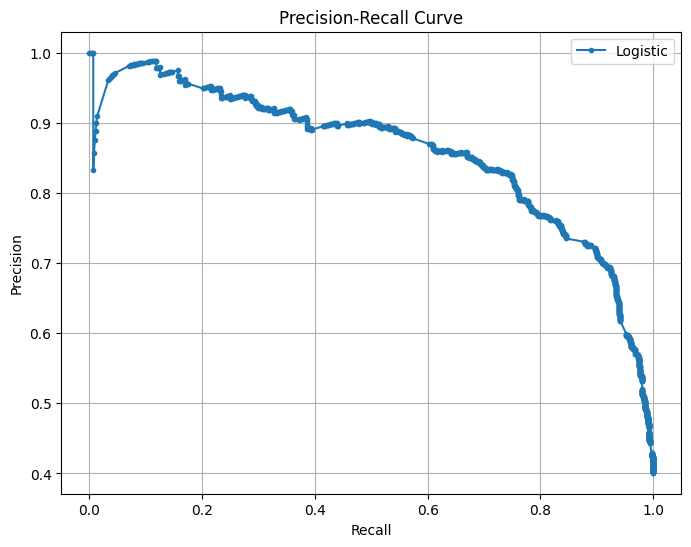

In [28]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Check p-values and VIF**

In [29]:
selected_features = X_train.columns[rfe.get_support()]
X_train_rfe_df = pd.DataFrame(X_train_rfe, columns=selected_features)



In [30]:
# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_train_rfe_df.values, i) for i in range(X_train_rfe_df.shape[1])]

print(vif_data)


                                              Feature        VIF
0                                         TotalVisits   2.311290
1                         Total Time Spent on Website   5.487706
2                                Page Views Per Visit   4.795935
3                                     AvgTimePerVisit   5.366661
4                 Lead Origin_Landing Page Submission   5.415677
5                           Lead Origin_Lead Add Form  20.305603
6                          Lead Source_Direct Traffic  22.698070
7                                  Lead Source_Google  24.064334
8                              Lead Source_Olark Chat  12.277399
9                          Lead Source_Organic Search  10.434344
10                              Lead Source_Reference  13.718471
11                         Lead Source_Referral Sites   1.987249
12                       Lead Source_Welingak Website   3.935732
13                                   Do Not Email_Yes   1.925154
14                       

## **Finding the Optimal Probability Cutoff and Evaluating with New Threshold**

- Determine the optimal threshold for classification to balance precision and recall

In [31]:
# Calculate F1 score for each threshold
f1_scores = [f1_score(y_test, (y_scores >= t).astype(int)) for t in thresholds]

# Find the threshold where F1 score is maximum
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold based on F1 Score:", optimal_threshold)

Optimal Threshold based on F1 Score: 0.29347124892215776


## **Generate the Score Variable**
- Generate a lead score variable based on the predicted probabilities to rank leads

In [32]:
# Get predicted probabilities for the test set from the best model
y_scores_best_model = best_model.predict_proba(X_test_rfe)[:, 1]

# Generate the score variable scaled by 100 for the test set
X_test['Score'] = y_scores_best_model * 100

## **Feature Importance Analysis and Strategic Recommendations**

In [33]:
# Define a function to calculate the threshold for a given recall level
def find_threshold_for_recall(precisions, recalls, thresholds, recall_level=0.9):
    recall_threshold = thresholds[np.argmax(recalls >= recall_level) - 1]
    return recall_threshold

# Define a function to calculate the threshold for a given precision level
def find_threshold_for_precision(precisions, recalls, thresholds, precision_level=0.9):
    precision_threshold = thresholds[np.argmax(precisions >= precision_level) - 1]
    return precision_threshold

# Call the functions with the desired level of precision and recall
aggressive_recall_threshold = find_threshold_for_recall(precisions, recalls, thresholds, recall_level=0.9)
conservative_precision_threshold = find_threshold_for_precision(precisions, recalls, thresholds, precision_level=0.9)

print(f"Aggressive Recall Threshold: {aggressive_recall_threshold:.2f}")
print(f"Conservative Precision Threshold: {conservative_precision_threshold:.2f}")

Aggressive Recall Threshold: 1.00
Conservative Precision Threshold: 0.75


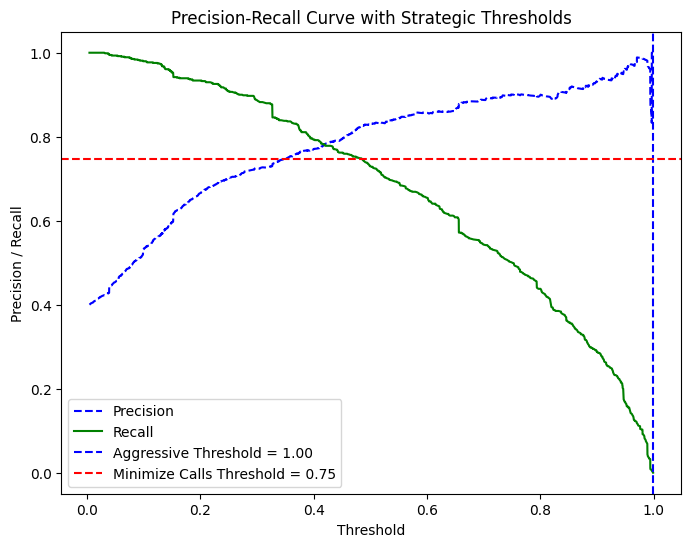

In [34]:
# Visualize Precision-Recall Curve with highlighted thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.axvline(x=aggressive_recall_threshold, color='blue', linestyle='--', label=f'Aggressive Threshold = {aggressive_recall_threshold:.2f}')
plt.axhline(y=conservative_precision_threshold, color='red', linestyle='--', label=f'Minimize Calls Threshold = {conservative_precision_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision-Recall Curve with Strategic Thresholds')
plt.legend(loc="best")
plt.show()

# Observations:


Overall Curve Shape: The curve starts near (1.0, 1.0), indicating a good initial performance, where both precision and recall are high. Then, it gradually curves downwards, signifying the expected trade-off between precision and recall. This is a typical behavior for classification models.

0.35 Threshold Intersection: It's challenging to pinpoint the exact 0.35 recall value on the X-axis due to how the data points are spaced, but here's an approximation:
Move up from the 0.35 mark on the X-axis until you visually intersect the curve. This happens roughly between the two plotted blue circles.
The corresponding precision value on the Y-axis is approximately 0.75.

In [35]:
# Extracting the coefficients from the logistic regression model
coefs = best_model.coef_[0]
feature_names = X_train.columns[rfe.support_]

# Create a dataframe of feature names and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

# Calculate the absolute value of the coefficients to assess their impact
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()

# Sort the features by the absolute value of their coefficients in descending order
top_features = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top 3 features
top_features.head(3)

,Feature,Coefficient,Absolute Coefficient
25,What is your current occupation_Working Profes...,3.195915,3.195915
5,Lead Origin_Lead Add Form,2.298192,2.298192
12,Lead Source_Welingak Website,1.901077,1.901077


# Conclusion:
It was found that the variables that mattered the most in the potential buyers are :
(Here provided in descending order) 

The total time spent on the Website.

Total number of visits.

When the lead source was:
--------------------------------------

Google

Direct traffic

Organic search

Welingak website

When the last activity was:
-------------------------------------
SMS

Olark chat conversation


When the lead origin is Lead add format.

These points highlight the systematic approach taken in the case study to address a common issue in sales and marketing through data analytics and predictive modeling.
